In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
import torch
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from transformers import (BitsAndBytesConfig, AutoProcessor,
                          LlavaForConditionalGeneration, GenerationConfig)

/anaconda/envs/dpml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'llava-hf/llava-1.5-7b-hf'
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.bfloat16)

model = LlavaForConditionalGeneration.from_pretrained(model_name,
                                                      quantization_config=quantization_config)
processor = AutoProcessor.from_pretrained(model_name)

/anaconda/envs/dpml_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]
/anaconda/envs/dpml_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load Data

In [2]:
df = pd.read_excel(f'/home/student/HallucinationsLLM/result_data.xlsx', index_col=0)

## EDA

In [3]:
def validate_brackets(string):
    counter = 0
    for c in string: 
        if c == "[":
            counter += 1 
        elif c == "]":
            counter -= 1
        if counter < 0 or counter > 1:
            return False 
    return True

In [4]:
def count_brackets(string):
    counter = 0
    for c in string: 
        if c == "[":
            counter += 1 
    return counter

In [5]:
cols_with_brackets = ['hallucinations', 'hedges', 'context_1', 'context_2', 'context_3', 'context_4']
for col in cols_with_brackets:
    validation_result = df[col].apply(lambda x: validate_brackets(x))
    passed_num = validation_result.astype(int).sum() 
    if passed_num != 150:
        print(f"{col} validation test failed: {passed_num}")

In [6]:
cols_with_brackets = ['hallucinations', 'hedges', 'context_1', 'context_2', 'context_3', 'context_4']
for col in cols_with_brackets:
    df[f'{col}_count'] = df[col].apply(lambda x: count_brackets(x))

<Axes: xlabel='hallucinations_count', ylabel='Count'>

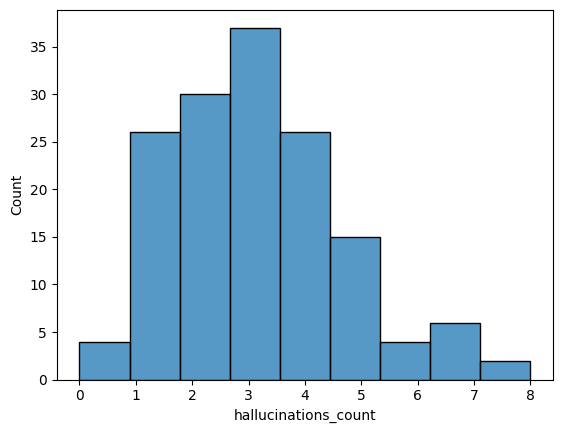

In [7]:
sns.histplot(data=df, x='hallucinations_count', bins=9)

In [8]:
import re
def clean_text(text):
    # Remove specific substrings
    text = re.sub(r'<0x0A>', ' ', text)
    text = re.sub(r'</s>', '', text)
    # Remove any other unwanted patterns (adjust the regex if needed)
    text = re.sub(r'<[^>]*>', '', text)
    return text.strip()

def count_words(text):
    words = text.split()
    return len(words)


def first_brackets_index(text):
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    for i, word in enumerate(words):
        if "[" in word:
            return i / len(words)
    return -1 

def extract_brackets_len(text):
    lens = []
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    for i, word in enumerate(words):
        if "[" in word:
            counter = 0
            for j in range(i, len(words)):
                counter += 1
                if "]" in words[j]:
                    break
            lens.append(counter)
    return lens


df['clean_description'] = df['description'].apply(clean_text)
df['description_len'] = df['clean_description'].apply(count_words)
df['first_hal_index'] = df['hallucinations'].apply(first_brackets_index)
df['hal_lens'] = df['hallucinations'].apply(extract_brackets_len)

In [9]:
hal_lens = []
for len_list in df['hal_lens'].values:
    hal_lens.extend(len_list)

In [10]:
def is_max_greater_than_3(lst):
    if len(lst) == 0:
        return False
    return max(lst) > 3

df[df['hal_lens'].apply(is_max_greater_than_3)].index

Index([  1,   2,   3,  13,  32,  33,  41,  44,  51,  53,  54,  58,  69,  70,
        72,  81,  82,  88,  89,  90,  92,  93,  94,  97, 100, 102, 103, 104,
       106, 107, 108, 110, 111, 112, 114, 115, 117, 118, 119, 120, 123, 124,
       128, 129, 131, 132, 133, 136, 137, 138, 139, 140, 143, 144, 145, 147,
       148],
      dtype='int64')

In [11]:
pd.Series(hal_lens).value_counts()

1     286
2      56
3      33
4      24
5      11
6      10
9       7
8       6
7       5
14      4
11      3
17      2
18      2
15      2
31      1
25      1
13      1
30      1
12      1
21      1
10      1
Name: count, dtype: int64

<Axes: xlabel='first_hal_index', ylabel='Count'>

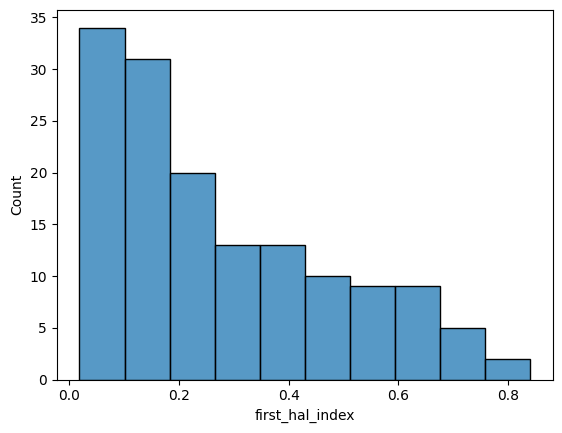

In [12]:
filtered_df = df[df['first_hal_index'] != -1]
sns.histplot(data=filtered_df, x='first_hal_index', bins=10)

In [13]:
pearsonr(df['description_len'], df['hallucinations_count'])

PearsonRResult(statistic=np.float64(0.2975767607904813), pvalue=np.float64(0.00021712795110060798))

In [14]:
pearsonr(df['hedges_count'], df['hallucinations_count'])

PearsonRResult(statistic=np.float64(0.03385592164590433), pvalue=np.float64(0.6808541189672309))

In [15]:
new_data = {
    'probe_number': [],
    'pred': [],
    'label': [],
    'prob': []
}

# Loop through each column group and append to new_data
for i in range(1, 5):
    new_data['probe_number'].extend([i] * len(df))
    new_data['pred'].extend(df[f'pred_{i}'])
    new_data['label'].extend(df[f'label_{i}'])
    new_data['prob'].extend(df[f'pred_{i}_prob'])

# Create the new DataFrame
new_df = pd.DataFrame(new_data)
new_df['correct_pred'] = (new_df['pred'] == new_df['label']).astype(int)
correct_df = new_df[new_df['correct_pred'] == 1]
wrong_df = new_df[new_df['correct_pred'] == 0]

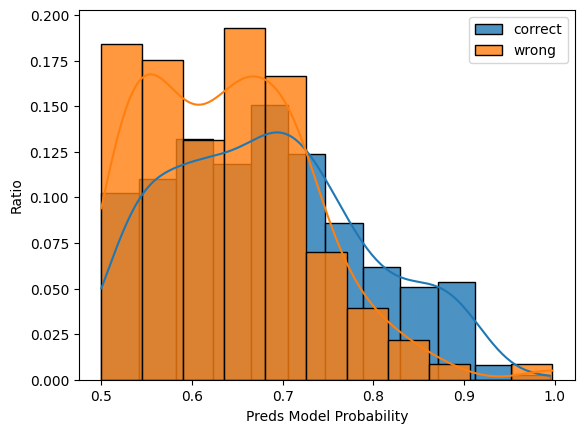

In [16]:
sns.histplot(data=correct_df, x="prob", kde=True, stat='probability', label="correct", alpha=0.8)
sns.histplot(data=wrong_df, x="prob", kde=True, stat='probability', label="wrong", alpha=0.8)
plt.legend()
plt.xlabel('Preds Model Probability')
plt.ylabel('Ratio')
plt.show()


In [17]:
df['hal_lens']

0                            [1]
1                   [6, 1, 4, 3]
2                            [4]
3                   [2, 2, 9, 1]
4                            [1]
                 ...            
145    [1, 10, 2, 2, 1, 1, 1, 1]
146                          [1]
147           [1, 1, 1, 1, 4, 1]
148                       [1, 9]
149                       [1, 1]
Name: hal_lens, Length: 150, dtype: object